### <b>Import Packages</b>

In [1]:
import pandas as pd
import numpy as np
import sklearn as sk
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
#sk.__version__

'0.23.2'

### <b>Import Data</b>

In [4]:
# df_h = pd.read_csv('/project_data/data_asset/Sample Heloc Data Dummy Values.csv')
# df_h.head()

In [3]:
import itc_utils.flight_service as itcfs

readClient = itcfs.get_flight_client()

nb_data_request = {'data_name': """Test_fields_100821_results.csv""", 'interaction_properties': {}}

flightInfo = itcfs.get_flight_info(readClient, nb_data_request=nb_data_request)

df1 = itcfs.read_pandas_and_concat(readClient, flightInfo)
df1.head()

,HALF,DOWNNUM,YARDSTOGO,SCOREDIFF,TIMELEFT,DOWNNAME,TRUEFIELD,YARDSGAINED_Mean,AVG_OVER_TOGO,PLAYIDSTR,RUN_PASS,CONCEPT_8,CONCEPT_9,pred_TD,prob_TD_NO,prob_TD_YES,pred_FIRST,prob_FIRST_NO,prob_FIRST_YES
0,0,0,5,0,480,1st,35,6.36,1.272,100000020,RUN,2,0,N,0.989180609,0.010819391,N,0.562406343,0.437593657
1,0,0,9,-7,1050,1st,45,4.756098,0.528455333,100000054,RUN,5,4,N,0.999278473,0.000721527,Y,0.439295772,0.560704228
2,0,2,4,7,600,3rd,5,8.164835,2.04120875,200000049,PASS,4,9,N,0.929719852,0.070280148,Y,0.391968242,0.608031758
3,0,0,11,7,180,1st,45,6.216667,0.565151545,200000041,PASS,4,1,N,0.999941376,5.86E-05,N,0.676802873,0.323197127
4,0,0,1,0,60,1st,45,13.416667,13.416667,200000085,PASS,8,5,N,0.800382789,0.199617211,N,0.60849475,0.39150525


In [4]:
from mytest_function import transform_mydata

In [5]:
df = transform_mydata(df1)
df.head()

,YARDSTOGO,SCOREDIFF,TIMELEFT,TRUEFIELD,CONCEPT_8,CONCEPT_9,YARDSGAINED_Mean,AVG_OVER_TOGO,prob_FIRST,TARGET_1ST,...,PLAYID_RUN1,PLAYID_RUN2,PLAYID_RUN3,PLAYID_RUN5,TEE_SHORT,TEE_MED,TEE_LONG,TEE_XLONG,DOWNNAME_1st,DOWNNAME_3rd
0,5,0,480,35,2,0,6.360000,1.272000,0.437594,0,...,0,1,0,0,0,1,0,0,1,0
1,9,-7,1050,45,5,4,4.756098,0.528455,0.560704,1,...,0,0,0,1,0,0,1,0,1,0
2,4,7,600,5,4,9,8.164835,2.041209,0.608032,1,...,0,0,0,0,0,1,0,0,0,1
3,11,7,180,45,4,1,6.216667,0.565152,0.323197,0,...,0,0,0,0,0,0,0,1,1,0
4,1,0,60,45,8,5,13.416667,13.416667,0.391505,0,...,0,0,0,0,1,0,0,0,1,0


## <b>Data Selection for Model Build</b>

 ### Model Build

We will build 2 models to predict First Down, one using Logistic Regression and one with Cross-Validation.

#### Data Preparation is complete. Step 1 is Sample Splitting 

First we will save a validation sample for testing the batch deployment

In [6]:
model_df = df.sample(frac=0.8, random_state=100)
#valid_df = df[~df.index.isin(model_df.index)]
print(len(model_df)) #,len(valid_df))

8000


Working with First Down predictions, we split the data, stratifying on selected data fields, always including y </br>
If desired, we can use the substitute scaled data for raw input variables. They have already been transformed into the appropriate array. 

In [7]:
from sklearn.model_selection import train_test_split

## https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

X = model_df.drop(columns = ['TARGET_1ST','STRAT_1ST'], axis = 1) ## We are using the same input variables, so the same scaled data will work. Only change is the target and stratification variables.
y = model_df['TARGET_1ST'].values

train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2, stratify = model_df.STRAT_1ST, random_state=121)

Now we run the Logistic Regression model

In [8]:
from sklearn.linear_model import LogisticRegression

## https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
# instantiate the model
logit = LogisticRegression()

# check the default parameters
#logit.get_params()

In [9]:
import warnings

#ignore by message
warnings.filterwarnings("ignore")

# fit the model with data using the default parameters
sk_logr = logit.fit(train_X,train_y)
#sk_logr.score(test_X, test_y)

In [10]:
import sklearn.pipeline
from sklearn.metrics import roc_curve, roc_auc_score
### call pipeline.predict() on your X_test data to make a set of test predictions
sk_pred = sk_logr.predict(test_X)

### test your predictions using sklearn.classification_report()
report = sklearn.metrics.classification_report(test_y, sk_pred)
print(report)

              precision    recall  f1-score   support

           0       0.73      0.69      0.71       607
           1       0.82      0.84      0.83       993

    accuracy                           0.78      1600
   macro avg       0.77      0.77      0.77      1600
weighted avg       0.78      0.78      0.78      1600



In [11]:
sklearn.metrics.f1_score(test_y, sk_pred)

0.8287841191066997

In [12]:
sk_probs = sk_logr.predict_proba(test_X)
#sk_probs

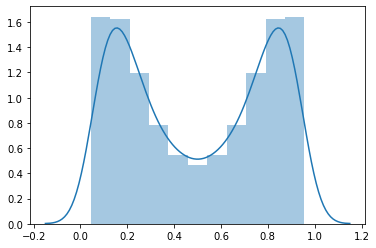

In [13]:
sns.distplot(sk_probs, kde=True, hist=True)

### Build a second model using Cross Validation

In [13]:
import warnings
warnings.filterwarnings("ignore")

from sklearn.linear_model import LogisticRegressionCV

# fit the model with data using the default parameters
cv_logr = LogisticRegressionCV(cv=7, random_state=0).fit(X, y)
#cv_logr.get_params()
#cv_logr.score(test_X, test_y)

In [14]:
cv_pred = cv_logr.predict(test_X)

report = sklearn.metrics.classification_report(test_y, cv_pred)
print(report)

              precision    recall  f1-score   support

           0       0.98      0.95      0.97       607
           1       0.97      0.99      0.98       993

    accuracy                           0.98      1600
   macro avg       0.98      0.97      0.97      1600
weighted avg       0.98      0.98      0.98      1600



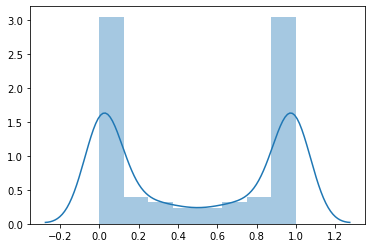

In [15]:
cv_probs = cv_logr.predict_proba(test_X)
cv_probs

sns.distplot(cv_probs, kde=True, hist=True)

### ROC Curve for Logistic Regression model

In [16]:
from my_roc_plot import plot_myroc

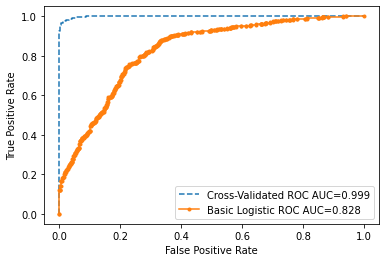

<module 'matplotlib.pyplot' from '/opt/conda/envs/Python-3.7-OpenCE/lib/python3.7/site-packages/matplotlib/pyplot.py'>

In [17]:
myplot = plot_myroc(sk_probs, cv_probs, test_y)
myplot

## Export Data back to project space

In [18]:
#model_df = df.sample(frac=0.8, random_state=100)
valid_df = df1[~df1.index.isin(model_df.index)]
print(len(model_df),len(valid_df))
#df1

8000 2000


In [19]:
from ibm_watson_studio_lib import access_project_or_space
wslib = access_project_or_space()
wslib.save_data("validation_data.csv", valid_df.to_csv(index=False).encode(),overwrite=True)

{'name': 'validation_data.csv',
 'asset_type': 'data_asset',
 'asset_id': 'data_asset.validationdatacsv',
 'attachment_id': '6b948fde-1524-4213-96eb-18602e4b80bb',
 'filepath': 'data_asset/validation_data.csv',
 'data_size': 214390,
 'mime': 'text/csv',
 'summary': ['looked up asset', 'selected attachment', 'overwritten file']}

### Re-import saved data and view it

In [20]:
import itc_utils.flight_service as itcfs

readClient = itcfs.get_flight_client()

nb_data_request = {'data_name': """validation_data.csv""", 'interaction_properties': {}}

flightInfo = itcfs.get_flight_info(readClient, nb_data_request=nb_data_request)

df_val = itcfs.read_pandas_and_concat(readClient, flightInfo)
print(df_val.shape)
df_val.head()

(2000, 19)


,HALF,DOWNNUM,YARDSTOGO,SCOREDIFF,TIMELEFT,DOWNNAME,TRUEFIELD,YARDSGAINED_Mean,AVG_OVER_TOGO,PLAYIDSTR,RUN_PASS,CONCEPT_8,CONCEPT_9,pred_TD,prob_TD_NO,prob_TD_YES,pred_FIRST,prob_FIRST_NO,prob_FIRST_YES
0,0,2,4,7,600,3rd,5,8.164835,2.04120875,200000049,PASS,4,9,N,0.929719852,0.070280148,Y,0.391968242,0.608031758
1,0,2,1,7,1140,3rd,5,13.16,13.16,200000062,PASS,6,2,N,0.918811506,0.081188494,Y,0.197842735,0.802157265
2,0,2,7,7,60,3rd,45,5.62,0.802857143,100000031,RUN,3,1,N,0.999992873,7.13E-06,N,0.546142512,0.453857488
3,0,0,3,-7,975,1st,5,11.895105,3.965035,200000083,PASS,8,3,Y,0.435497017,0.564502983,Y,0.499266757,0.500733243
4,0,2,4,7,600,3rd,5,5.62,1.405,100000010,RUN,1,0,N,0.621614407,0.378385593,Y,0.455149394,0.544850606
